<a href="https://colab.research.google.com/github/starhou/images-inpainting-with-gan/blob/master/mynetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks


In [0]:
!pwd

###导入相关包

In [0]:

from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
tf.enable_eager_execution()

In [0]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import PIL

from IPython import display
import pylab as pl

import pickle


In [0]:
print(tf.VERSION)
print(tf.keras.__version__)

###从文件夹下读取数据

In [0]:
trainset_path = 'data/lsun_trainset.pickle'
testset_path  = 'data/lsun_testset.pickle'
dataset_path = 'data/data1/'


读取训练集和测试集的路径

In [0]:
lsun_images = []
for _, _, dir, in os.walk(dataset_path):
  lsun_images.extend(dir)

lsun_images = list(map(lambda x: dataset_path+x, lsun_images))  
lsun_images = np.array(lsun_images)

trainset = lsun_images[:int(len(lsun_images)*0.9)]
testset = lsun_images[int(len(lsun_images)*0.9):]
trainset

In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [0]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [0]:
num = 0
for imgpath in trainset[:2000]:
  img = load_img(imgpath)
  if num==0:
    train_data = tf.stack(img, axis=0)
  else:
    train_data = tf.concat([train_data,img], axis=0)
  num+=1;

  
num=0
for imgpath in testset[:100]:
  img = load_img(imgpath)
  if num==0:
    test_data = tf.stack(img, axis=0)
  else:
    test_data = tf.concat([test_data,img], axis=0)
  num+=1;
print(train_data.shape)
print(test_data.shape)

读取数据并序列化

In [0]:
output = open('train.pkl', 'wb')
pickle.dump(train_data, output)
output.close()

output = open('test.pkl', 'wb')
pickle.dump(test_data, output)
output.close()

###定义输入管道

加载数据

In [5]:
pkl_file = open('train.pkl', 'rb')
train_data = pickle.load(pkl_file)
pkl_file.close()
print(np.shape(train_data))

pkl_file = open('test.pkl', 'rb')
test_data = pickle.load(pkl_file)
pkl_file.close()
print(np.shape(test_data))
type(test_data)

(500, 511, 418, 3)
(100, 511, 418, 3)


tensorflow.python.framework.ops.EagerTensor

In [0]:
train_data = tf.image.resize(train_data, (200, 200))
test_data = tf.image.resize(test_data, (200, 200))

随机生成破损图像

In [0]:
def mask_randomly(imgs):
  
  mask_height = 65
  mask_width = 65
  channels = 3
  img_rows = imgs[0].shape[1]

  y1 = np.random.randint(0, img_rows - mask_height, len(imgs))
  y2 = y1 + mask_height
  x1 = np.random.randint(0, img_rows -mask_width, len(imgs))
  x2 = x1 + mask_width

  masked_imgs = np.empty_like(imgs)
  missing_parts = np.empty((len(imgs), mask_height, mask_width, channels))
  real_parts = np.empty((len(imgs), mask_height, mask_width, channels))
  for i, img in enumerate(imgs):
    masked_img = img.copy()
    _y1, _y2, _x1, _x2 = y1[i], y2[i], x1[i], x2[i]
    missing_parts[i] = masked_img[_y1:_y2, _x1:_x2, :].copy()
    real_parts[i] = masked_img[_y1:_y2, _x1:_x2, :].copy()
    masked_img[_y1:_y2, _x1:_x2, :] = 0
    masked_imgs[i] = masked_img

  return masked_imgs,missing_parts,real_parts,(y1, y2, x1, x2)


准备好训练集和测试集

In [0]:
TRAIN_BUF = 10
BATCH_SIZE = 1
mytrain_data = tf.data.Dataset.from_tensor_slices(train_data).shuffle(TRAIN_BUF).batch(BATCH_SIZE)

###创建网络


构建网络  生成器

In [0]:
def generator():
  generate = tf.keras.Sequential(
    [   #encoder
        tf.keras.layers.InputLayer(input_shape=(200, 200, 3)),
        tf.keras.layers.Conv2D(
            filters=64, kernel_size=3, strides=(2, 2), activation='relu',padding='same'),
        tf.keras.layers.Conv2D(
            filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
        tf.keras.layers.Conv2D(
            filters=16, kernel_size=3, strides=(2, 2), activation='relu'),
        tf.keras.layers.Conv2D(
            filters=8, kernel_size=3, strides=(2, 2), activation='relu'),
        tf.keras.layers.Conv2D(
            filters=4, kernel_size=3, strides=(2, 2), activation='relu'),

        # mid contact layer
        tf.keras.layers.Dense(4),

        #decoder
        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.Conv2D(
            filters=4, kernel_size=3,  activation='relu',padding='same'),
        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.Conv2D(
            filters=8, kernel_size=3,  activation='relu'),
        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.Conv2D(
            filters=16, kernel_size=3, activation='relu'),
        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.Conv2D(
            filters=32, kernel_size=3,  activation='relu'),
        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.Conv2D(
            filters=3, kernel_size=3, strides=(2, 2),activation='relu'),    

    ]
  )

  return generate
    
    
  
  

判别器

In [0]:
def discriminator():
  discriminate = tf.keras.Sequential(
      [
        tf.keras.layers.InputLayer(input_shape=(65,65,3)),
        tf.keras.layers.Conv2D(
            filters=32, kernel_size=3, activation='relu',padding='same'),
        tf.keras.layers.Conv2D(
            filters=16, kernel_size=3, activation='relu',padding='same'),
        # No activation
        tf.keras.layers.Conv2D(
            filters=8, kernel_size=3,  activation='relu',padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1,activation='sigmoid')
      ]
  )
  return discriminate
    
    

实例化

In [0]:
generator = generator()
discriminator = discriminator()

定义损失函数

In [0]:
def discriminator_loss(real_output, generated_output):
    """The disciminator loss function."""
    bce = tf.keras.losses.BinaryCrossentropy()
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(generated_output), generated_output)


def generator_loss(real_parts, generated_images,generated_output):
    """The Generator loss function."""
    bce = tf.keras.losses.MeanSquaredError()
    cce = tf.keras.losses.BinaryCrossentropy()
    return bce(real_parts, generated_images)+ cce(tf.ones_like(generated_output), generated_output)

定义优化器

In [0]:
generator_optimizer = tf.train.AdamOptimizer(1e-4)
discriminator_optimizer = tf.train.AdamOptimizer(1e-4)

###定义单步参数更新

In [0]:
# Let's play the min-max game
if not os.path.exists("./gif/"):
   os.makedirs("./gif/")

单步迭代

In [0]:

def train_step(images):
  
   # generating noise from a normal distribution
  masked_imgs,missing_parts,real_parts,(y1, y2, x1, x2) = mask_randomly(np.array (images))

  masked_imgs = tf.convert_to_tensor(np.array(masked_imgs),name = 'masked_imgs',dtype=tf.float32)
  real_parts= tf.convert_to_tensor(np.array(real_parts),name = 'real_parts',dtype=tf.float32)
    
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    
    generated_images = generator(masked_imgs)

    real_output = discriminator(real_parts)
    generated_output = discriminator(generated_images)

    gen_loss = generator_loss(real_parts,generated_images,generated_output)
    disc_loss = discriminator_loss(real_output, generated_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
  
  del gen_tape
  del disc_tape
  
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))
  return real_parts, generated_images, gen_loss, disc_loss,(y1, y2, x1, x2),masked_imgs

In [0]:
iterator = mytrain_data.make_one_shot_iterator()

In [0]:
# fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
# for step in range(100):
  
#   try:
#     mytrain_next = iterator.get_next()
#   except tf.errors.OutOfRangeError:
#     print("End of dataset")
#     break
  


#   if step % 20 == 0:
#       print("G loss: ", g_loss_value.numpy(), " D loss: ", d_loss_value.numpy(), " step: ", step)
#       show_and_save_images(real_part_data,fake_part_data,y1, y2, x1, x2, masked_imgs, fig, axs, step)
      

In [0]:
def show_and_save_images(real_data,fake_data,y1, y2, x1, x2, masked_imgs, fig, axs, name):
  
  real_data = np.squeeze(np.array(real_data))
  fake_data = np.squeeze(np.array(fake_data))
  masked_imgs = np.squeeze(np.array(masked_imgs))
  imgs = masked_imgs.copy()
  imgs[int(y1):int(y2), int(x1):int(x2), :]=real_data

  axs[0].imshow(imgs)
  axs[0].axis('off')
  filled_in = masked_imgs.copy()
  filled_in[int(y1):int(y2), int(x1):int(x2), :]=fake_data
  axs[1].imshow(filled_in)
  axs[1].axis('off')
  
  axes = plt.gca()
  display.display(pl.gcf())
  display.clear_output(wait=True)
  plt.savefig("./gif/{}.png".format(name))
  
#   plt.gca().clear()
#   time.sleep(1)


定义保存图片

###定义训练

In [0]:
def train(mytrain_data,epochs,test_data,name):  
  for epoch in range(epochs):
    start = time.time()
    iterator = mytrain_data.make_one_shot_iterator()
    fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
    for step in range(4000):

      try:
        mytrain_next = iterator.get_next()
      except tf.errors.OutOfRangeError:
        print("End of dataset")
        break

      real_part_data, fake_part_data,g_loss_value, d_loss_value,(y1, y2, x1, x2),masked_imgs= train_step(mytrain_next)
      
      if step % 200 == 0:
          print("G loss: ", g_loss_value.numpy(), " D loss: ", d_loss_value.numpy(), " name: ", name)
          show_and_save_images(real_part_data,fake_part_data,y1, y2, x1, x2, masked_imgs, fig, axs, name)
          name=name+1
          


训练并保存

G loss:  0.050261255  D loss:  15.942385  name:  19


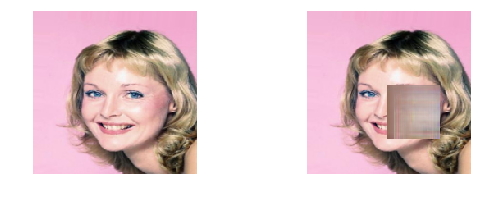

In [0]:
%%time

discriminator.load_weights('./discriminator.h5')
generator.load_weights('./generator.h5')
name=0

  
train(mytrain_data,100,test_data,name)
  
generator.save_weights('./generator.h5', save_format='h5')
discriminator.save_weights('./discriminator.h5', save_format='h5')

